<a href="https://colab.research.google.com/github/rhysdavies21/library/blob/master/financial_formulae_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Financial Formulae**

Black-Scholes

In [0]:
import numpy as np
from scipy.stats import norm

def black_scholes_analytical(s_0, k, T, r, sigma, type='call'):
  d1 = (np.log(s_0/k) + (r + 0.5*sigma**2) *T) / (sigma*np.sqrt(T))
  d2 = (np.log(s_0/k) + (r - 0.5*sigma**2) *T) / (sigma*np.sqrt(T))
  if type == 'call':
    val = s_0 * norm.cdf(d1,0,1) - k*np.exp(-r*T)*norm.cdf(d2,0,1)
  elif type == 'put':
    val = k*np.exp(-r*T)*norm.cdf(-d2,0,1)-s_0 * norm.cdf(-d1,0,1)
  return round(val, 5)

In [0]:
# Calculate black_scholes_analytical

s_0_val = 100
k_val = 100
r_val = 0.05
sigma_val = 0.15
T_val =  1
type_val = 'call'    # or 'put'
decimals = 4

round(black_scholes_analytical(s_0_val, k_val, T_val, r_val, sigma_val, type_val), 4)

8.5917

In [0]:
# Calculate implied volatility from option price

def imp_vol(pv, s_0, k, r, T, type, epsilon, max_sigma, inc_sigma):
  sigma = 0.00001
  sigma_final = 0
  while sigma < max_sigma:
    pv_iter = black_scholes_analytical(s_0, k, T, r, sigma, type)
    abs_diff = abs(pv - pv_iter)
    if abs_diff < epsilon:
      sigma_final = sigma
      sigma = max_sigma + 1000000
      break
    sigma += inc_sigma
  return sigma_final

In [0]:
# Run calculations

pv_val = 9
s_0_val = 100
k_val = 100
r_val = 0.05
T_val =  1
type_val = 'call'    # or 'put'
epsilon_val = 0.01
max_sigma_val = 2
inc_sigma_val = 0.001
decimals = 4

round(imp_vol(pv_val, s_0_val, k_val, r_val, T_val, type_val, 
        epsilon_val, max_sigma_val, inc_sigma_val), decimals)

0.161

Black's Formula

In [0]:
# Define Black '76 function
from scipy.stats import norm
import math 

def black(f_0, strike, expiry, vol, rate, c_p):
    d_plus = (math.log(f_0 / strike) + 0.5 * vol * vol * expiry)/(vol / math.sqrt(expiry))
    d_minus = (math.log(f_0 / strike) - 0.5 * vol * vol * expiry)/(vol / math.sqrt(expiry))
    if c_p == 'c':
            option_value = (math.exp((-rate)*expiry))*(f_0 * norm.cdf(d_plus) - strike *norm.cdf(d_minus))
    elif c_p == 'p':
            option_value = (math.exp((-rate)*expiry))*(strike * norm.cdf(-d_minus) - f_0 *norm.cdf(-d_plus))
    else:
            print('Check input')
    return option_value

In [0]:
# Request inputs
c_p = str(input('call (c) or put (p) = '))

f_0 = 0.07
strike = 0.08
expiry = 1
black_vol = 0.2
rate = 0.05

# Price option
if c_p in ['c', 'p']:
  black_price = black(f_0, strike, expiry, black_vol, rate, c_p)
  print('\n' "black_price = "+"{:.3%}".format(black_price))
else:
  print('Check input')

call (c) or put (p) = c

black_price = 0.214%


Bachelier Formula

In [0]:
# Define Bachelier
from scipy.stats import norm
import math

def dPlusBachelier(F_0 , y, expiry , vol):
    d_plus = (F_0 - y)/ (vol * math.sqrt(expiry))
    return d_plus

def bachelier(F_0, y, expiry, vol, rfr, type):
    if expiry * vol == 0.0:
        if type == 'isCall':
            option_value = max(F_0 - y, 0.0)
        elif type == 'isPut':
            option_value = max(y - F_0 , 0.0)
        else:
            option_value = 'Not defined'
    else:
        d1 = dPlusBachelier(F_0, y, expiry, vol)
        if type == 'isCall':
             option_value = (math.exp((-rfr)*expiry))*((F_0 - y)* norm.cdf(d1) + vol * math.sqrt(expiry) * norm.cdf(d1))
        elif type == 'isPut':
             option_value = (math.exp((-rfr)*expiry))*((y-F_0) * norm.cdf(-d1) + vol * math.sqrt(expiry) * norm.cdf(-d1))
        else: option_vale = 'Not defined'
    return option_value

In [0]:
# Run Bachelier 

# Input
F_0_val = 0.07
y_val = 0.08
expiry_val = 2
vol_val = 0.2
rfr_val = 0.07
type_val = 'isCall'   # or 'isPut'

# Output
bachelier_price = bachelier(F_0_val, y_val, expiry_val, vol_val, rfr_val, type_val)
print('bachelier_price = '+'{:.3%}'.format(bachelier_price))

bachelier_price = 11.525%


SABR

In [0]:
# Define SABR Volatility function  # requires testing for term structure
import math

def sabr_vol(alpha, beta, rho, v, f, k, T):
  bb = alpha / (f**(1-beta))
  if k <= 0:                       # For negative rates shift smile
    sabr_vol = 0
    #note = 'No volatility since negative rates'
  elif f ==  k:
    z = 0
    x = 0
    sabr_vol = bb * (1+ ( (1-beta)*(1-beta)*alpha*alpha/(24*(f**(2-2*beta))) 
    + alpha*beta*rho*v/(4*(f**(1-beta))) + (2-3*rho*rho)*v*v/24) * T )
    note = 'ATM'
  elif f != k:
    z = (v/alpha) * (f*k) ** ((1-beta)/2) * math.log(f/k)
    x = math.log(  ( math.sqrt(1-2*rho*z+z*z) + z - rho ) / (1-rho) )
    denominator =  (1 + ((1-beta)**2)*(1/24) * ((math.log(f/k))**2)+
                   ((1-beta)**4)*(1/1920) * ((math.log(f/k))**4) )
    numerator = ( 1 + ( ((1-beta)**2)*(1/24) * (alpha**2)/((f*k)**(1-beta)) +
                      (1/4)*rho*beta*v*alpha/((f*k)**((1-beta)/2)) + 
                      (2-3*rho*rho)*(1/24)*v*v ) * T )
    sabr_vol = v * math.log(f/k) * (1 / x) * (numerator / denominator)
    note = 'Not ATM'
    
    my_z = z
    my_x = x
    my_numerator = numerator
    my_denominator = denominator

  return round(sabr_vol, 10)

#  Tested against:   https://www.dropbox.com/s/pw9pn1dtu6bz5o9/SABR.py?dl=0
#  referenced from: TRAVAGLINI_SABR_calibration_in_Python

In [0]:
# Run SABR calculation example

# Input
alpha_val = 0.2
beta_val = .2
f_val = 0.03
k_val = 0.09
v_val = 0.5
rho_val = 0.5
T_val = 3

# Output
print('SABR', sabr_vol(alpha_val, beta_val, rho_val, v_val, f_val, k_val, T_val))

SABR 3.272972092


In [0]:
# Volatility table in pandas dataframe
import pandas as pd

# Input
alpha_val = 0.2
beta_val = 1
f_val = 0.07
v_val = 0.2
rho_val = -0.3

strikes = [0.01, 0.02, 0.03]
maturities = [0.25, 0.5]

vol_table = []   
for strike in strikes:
  vol_rows = []
  for maturity in maturities:
    vol_s_t = sabr_vol(alpha_val, beta_val, rho_val, v_val, f_val, strike, maturity)
    vol_rows.append(vol_s_t)
  vol_table.append(vol_rows)

df1 = pd.DataFrame(vol_table, columns = maturities)
df1.insert(loc=0, column='Strikes_Col', value=strikes)
df1

,Strikes_Col,0.25,0.5
0,0.01,0.303514,0.303505
1,0.02,0.262606,0.262598
2,0.03,0.239283,0.239276


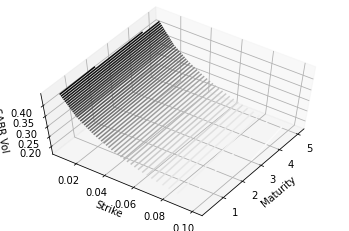

In [0]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Input
alpha_val = 0.2
beta_val = 1
f_val = 0.07
v_val = 0.4
rho_val = -0.6

strikes = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
maturities = [0.25, 0.5, 1, 2, 3, 4, 5]

X = maturities
Y = strikes

X, Y = np.meshgrid(X, Y)
sabr_vol_vec = np.vectorize(sabr_vol)
Z = sabr_vol_vec(alpha_val, beta_val, rho_val, v_val, f_val, Y, X)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('Maturity')
ax.set_ylabel('Strike')
ax.set_zlabel('SABR Vol');
ax.invert_xaxis()
ax.view_init(60, 35)